In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os

In [2]:
m = 2000; M = 12000; 
bin_size = 5
step_size = 1; # interpolation step size

path = "D:/GitHub/Machine-Learning/Kaggle/"

savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;
    
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

def remove_noise(df):
    N = len(df)  # number of samples
    idx_list = []
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]

        if np.var(intensity) < 100:
          idx_list.append(idx)
          print('Training sample', idx, ' eliminated')
    new_df = df.drop(index = idx_list)
    return new_df

df_train = remove_noise(df_train)

Training sample 339  eliminated
Training sample 490  eliminated


In [6]:
def interpolate_spectra(df, m, M, step_size):
    # step_size is the size of each step; 1 interpolates very well.
    mz_range = np.arange(m,M+1,step_size)
    
    N = len(df)  # number of samples
    L = len(mz_range)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    idx_list = []
    
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]       
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        interpolated_spectrum = np.interp(x=mz_range,xp=mzcoord,fp=intensity)
        interpolated_spectrum = interpolated_spectrum / np.max(interpolated_spectrum)
        all_data[idx,:] = interpolated_spectrum
    new_df = pd.DataFrame(data=all_data, columns = mz_range, index = df.index)
    plt.show()
    return new_df

In [7]:
# df_train = df_train.drop_duplicates(subset='ID_sample') # eliminate duplicates
# Let's work without duplicates from now on, to avoid having same sample in training and test_training sets

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=0) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = interpolate_spectra(data_train,m,M,step_size)
spectrum_test_train = interpolate_spectra(data_test_train,m,M,step_size)
print('Spectrum interpolated!')
# these spectrum_... are our X for training

Training samples: 359 and test_train samples: 155
Spectrum interpolated!


In [11]:
from scipy.signal import find_peaks_cwt

def spectrum_in_peaks(spectrum,peak_width):
    df = spectrum.copy()
    spectrum  = spectrum.to_numpy()
    new_spectrum = np.zeros(spectrum.shape)
    
    for i,x in enumerate(spectrum):
        spectrum_train_aux = np.zeros(len(x))
        peaks =  find_peaks_cwt(vector=x,widths=peak_width)
        spectrum_train_aux[peaks] = x[peaks]
        new_spectrum[i,:] = spectrum_train_aux

    new_df = pd.DataFrame(data=new_spectrum, columns = df.columns, index = df.index)
    return new_df

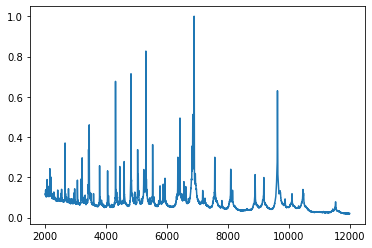

In [12]:
# let's try this function with different peak width and visualize the results
plt.plot(spectrum_train.iloc[0,:],label='Interpolated spectrum')

new_df = spectrum_in_peaks(spectrum_train,[1,5,10,20,30,50])

1.88 % of points


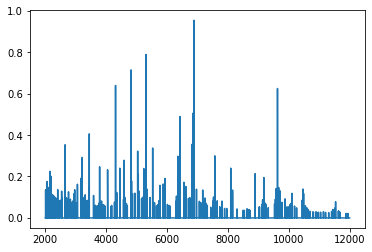

In [19]:
plt.plot(new_df.iloc[0,:],label='Peaks')
print(np.round(np.sum(new_df.iloc[0,:]>0) *100/ len(new_df.iloc[0,:]),2) ,'% of points')

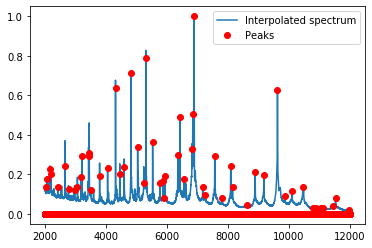

In [23]:
# let's try this function with different peak width and visualize the results
plt.plot(spectrum_train.iloc[0,:],label='Interpolated spectrum')
plt.plot(new_df.iloc[0,:],'ro',label='Peaks')
plt.legend()
plt.show()

[1, 5, 10]


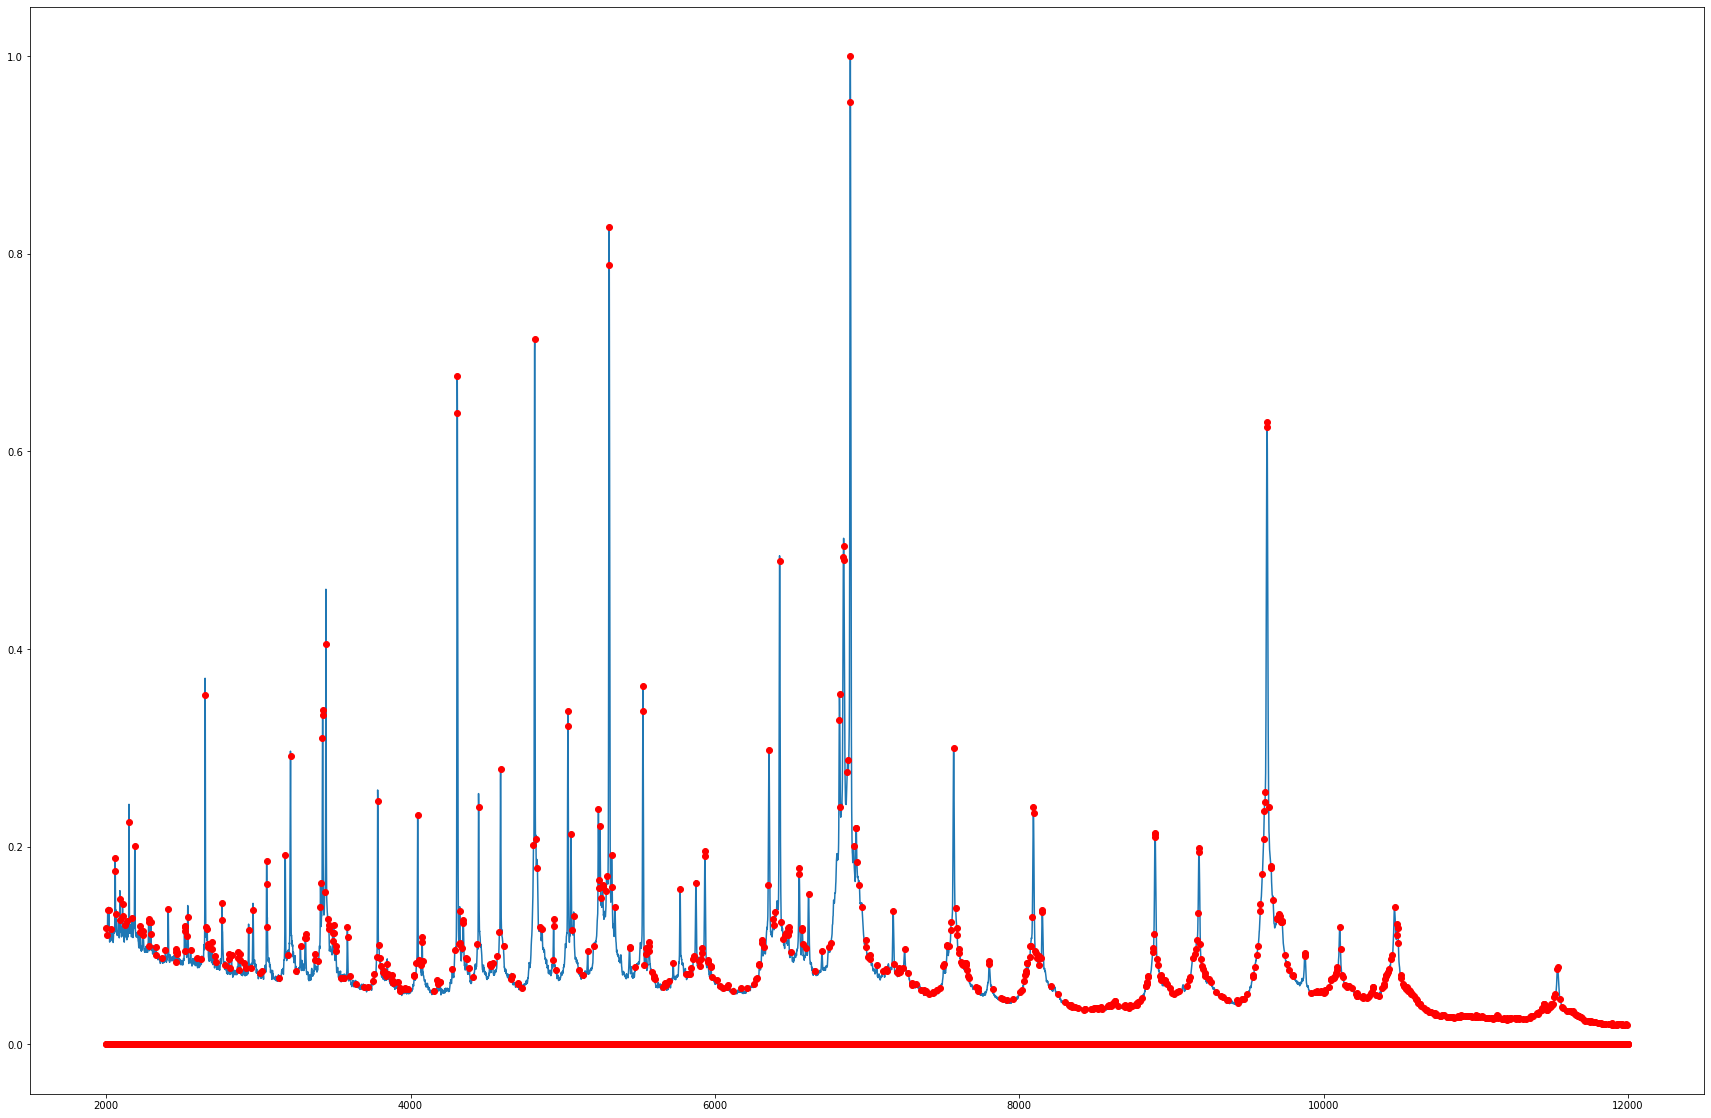

7.83 % of points
[10]


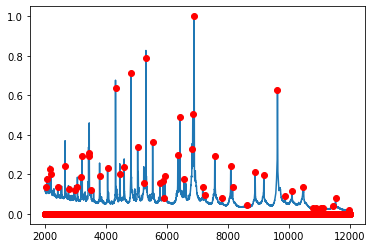

0.55 % of points
[5]


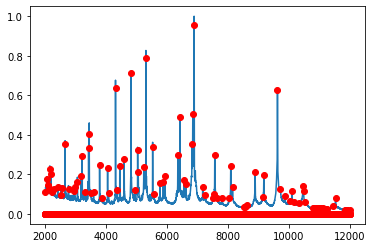

0.93 % of points
[1]


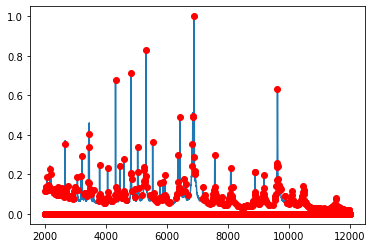

No handles with labels found to put in legend.


4.78 % of points


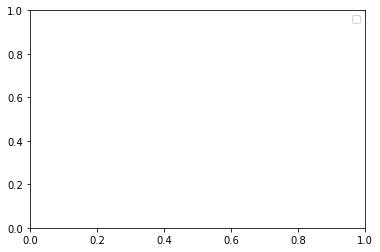

In [27]:
# let's plot for different widths

for i,n in enumerate([[1,5,10],[10],[5],[1]]):
    print(n)
    new_df = spectrum_in_peaks(spectrum_train,n)
    plt.figure(figsize=(30,20))
    plt.plot(spectrum_train.iloc[0,:],label='Interpolated spectrum')
    plt.plot(new_df.iloc[0,:],'ro',label='Peaks')
    plt.show()
    print(np.round(np.sum(new_df.iloc[0,:]>0) *100/ len(new_df.iloc[0,:]),2) ,'% of points')
plt.legend()
plt.show()

[15]


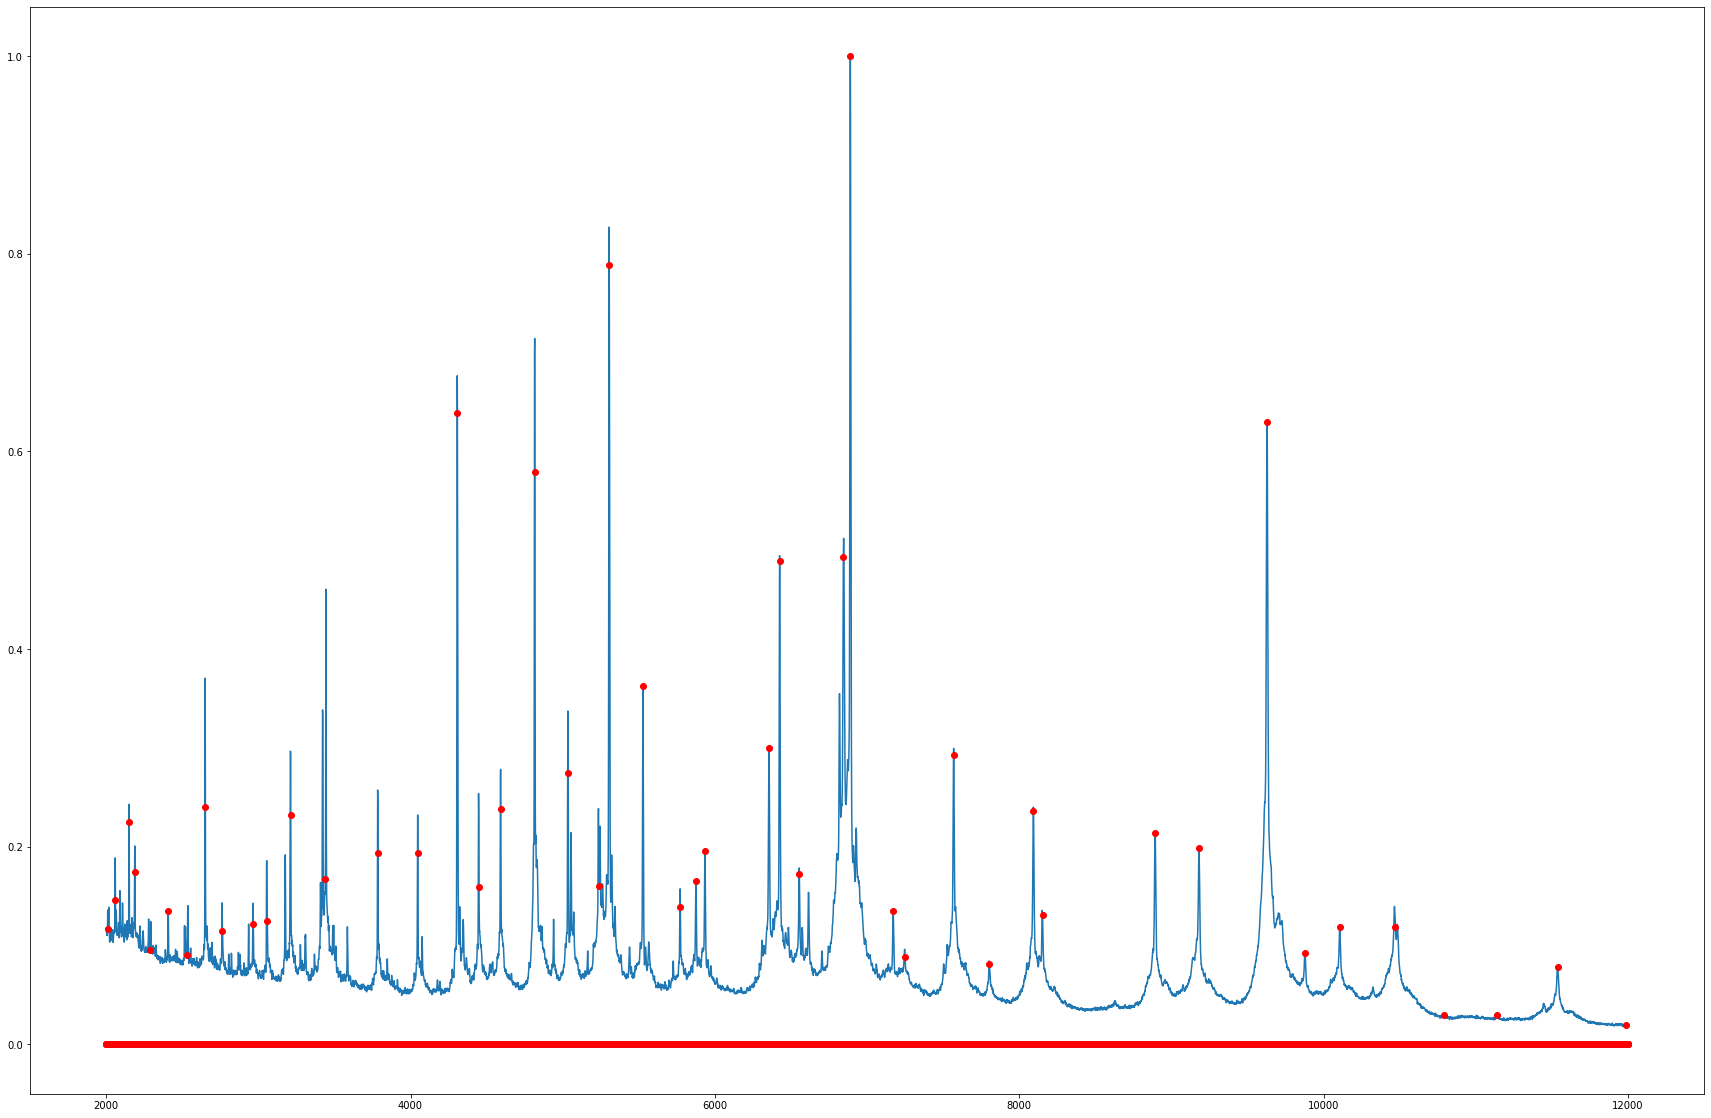

0.47 % of points
[20]


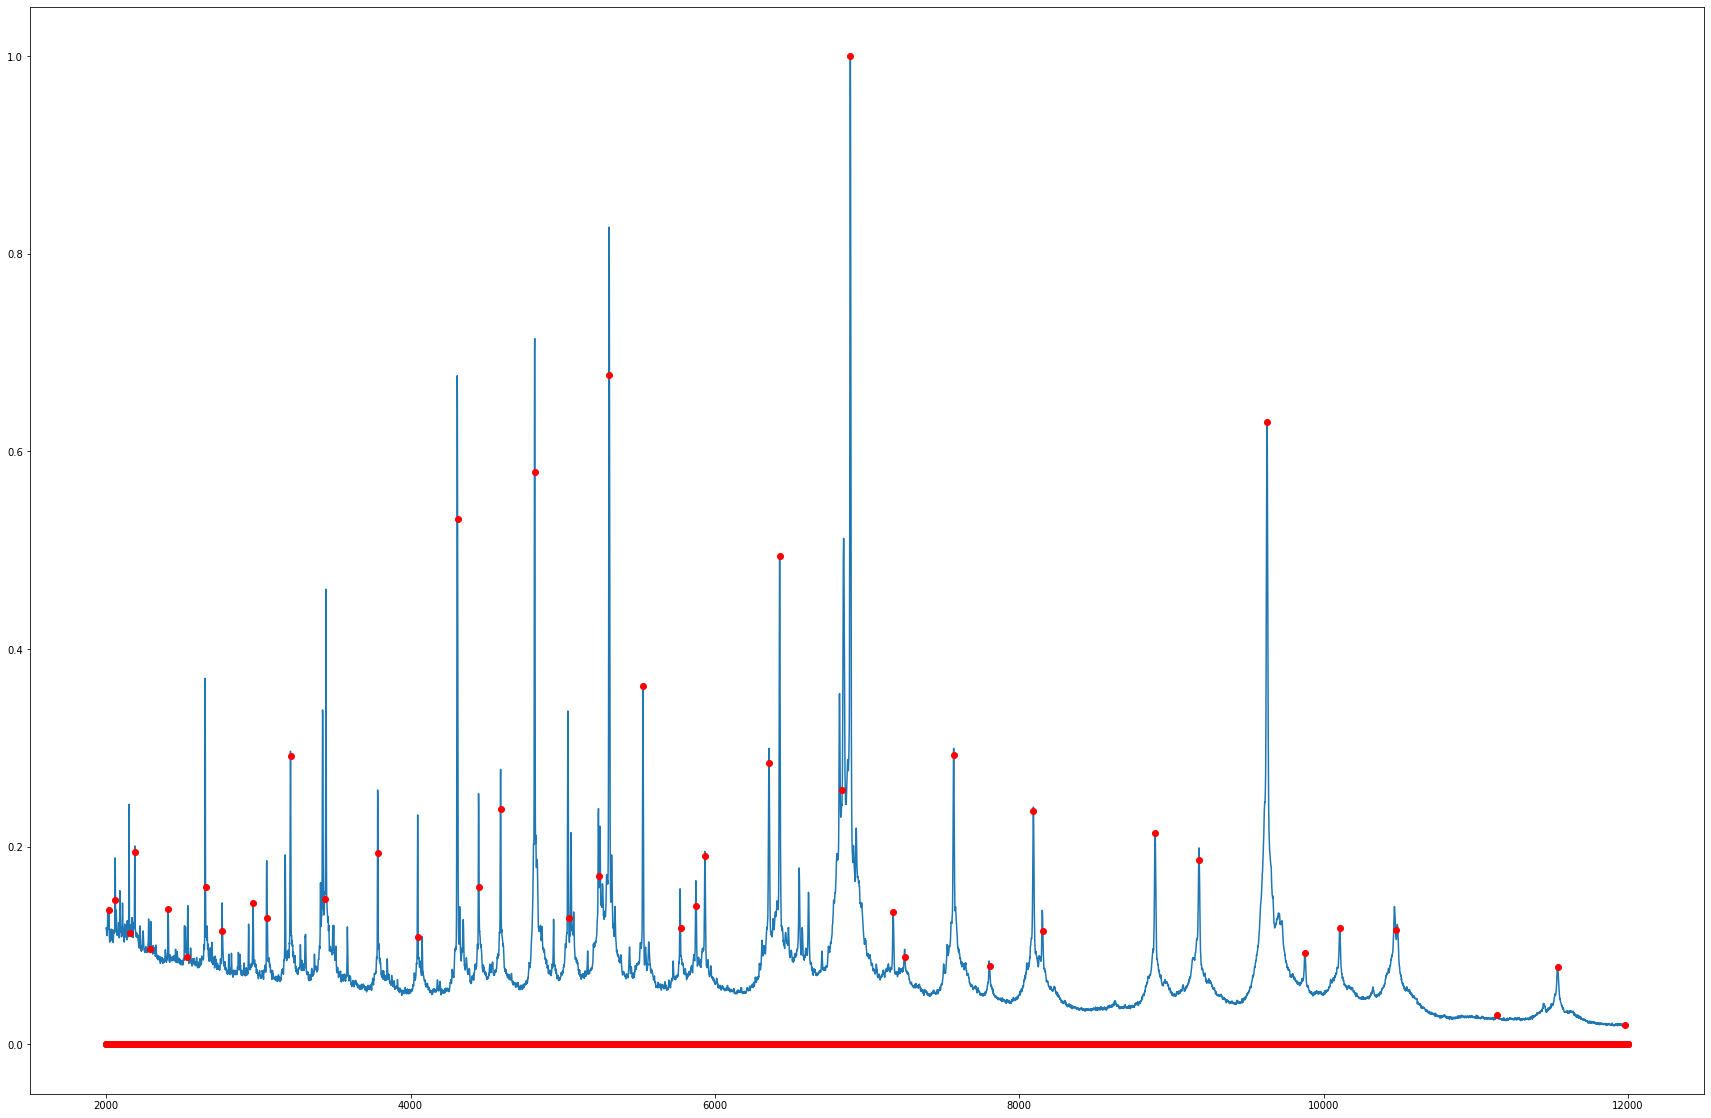

No handles with labels found to put in legend.


0.45 % of points


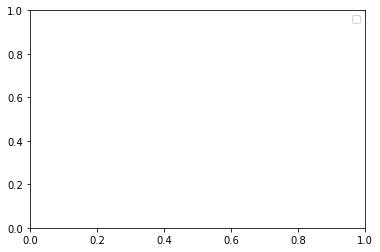

In [28]:
for i,n in enumerate([[15],[20]]):
    print(n)
    new_df = spectrum_in_peaks(spectrum_train,n)
    plt.figure(figsize=(30,20))
    plt.plot(spectrum_train.iloc[0,:],label='Interpolated spectrum')
    plt.plot(new_df.iloc[0,:],'ro',label='Peaks')
    plt.show()
    print(np.round(np.sum(new_df.iloc[0,:]>0) *100/ len(new_df.iloc[0,:]),2) ,'% of points')
    plt.legend()
    plt.show()

TODO: use spectrum_in_bins (now with interpolation) and then find peaks,
and check if amplitudes are truly kept

In [30]:
def spectrum_in_bins_2(df, m, M, bin_size): # new version
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_mean = [];
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)  

        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    return new_df

In [31]:
bin_size = 5
spectrum_train2 = spectrum_in_bins_2(data_train,m,M,bin_size)

[5]
1.6 % of points


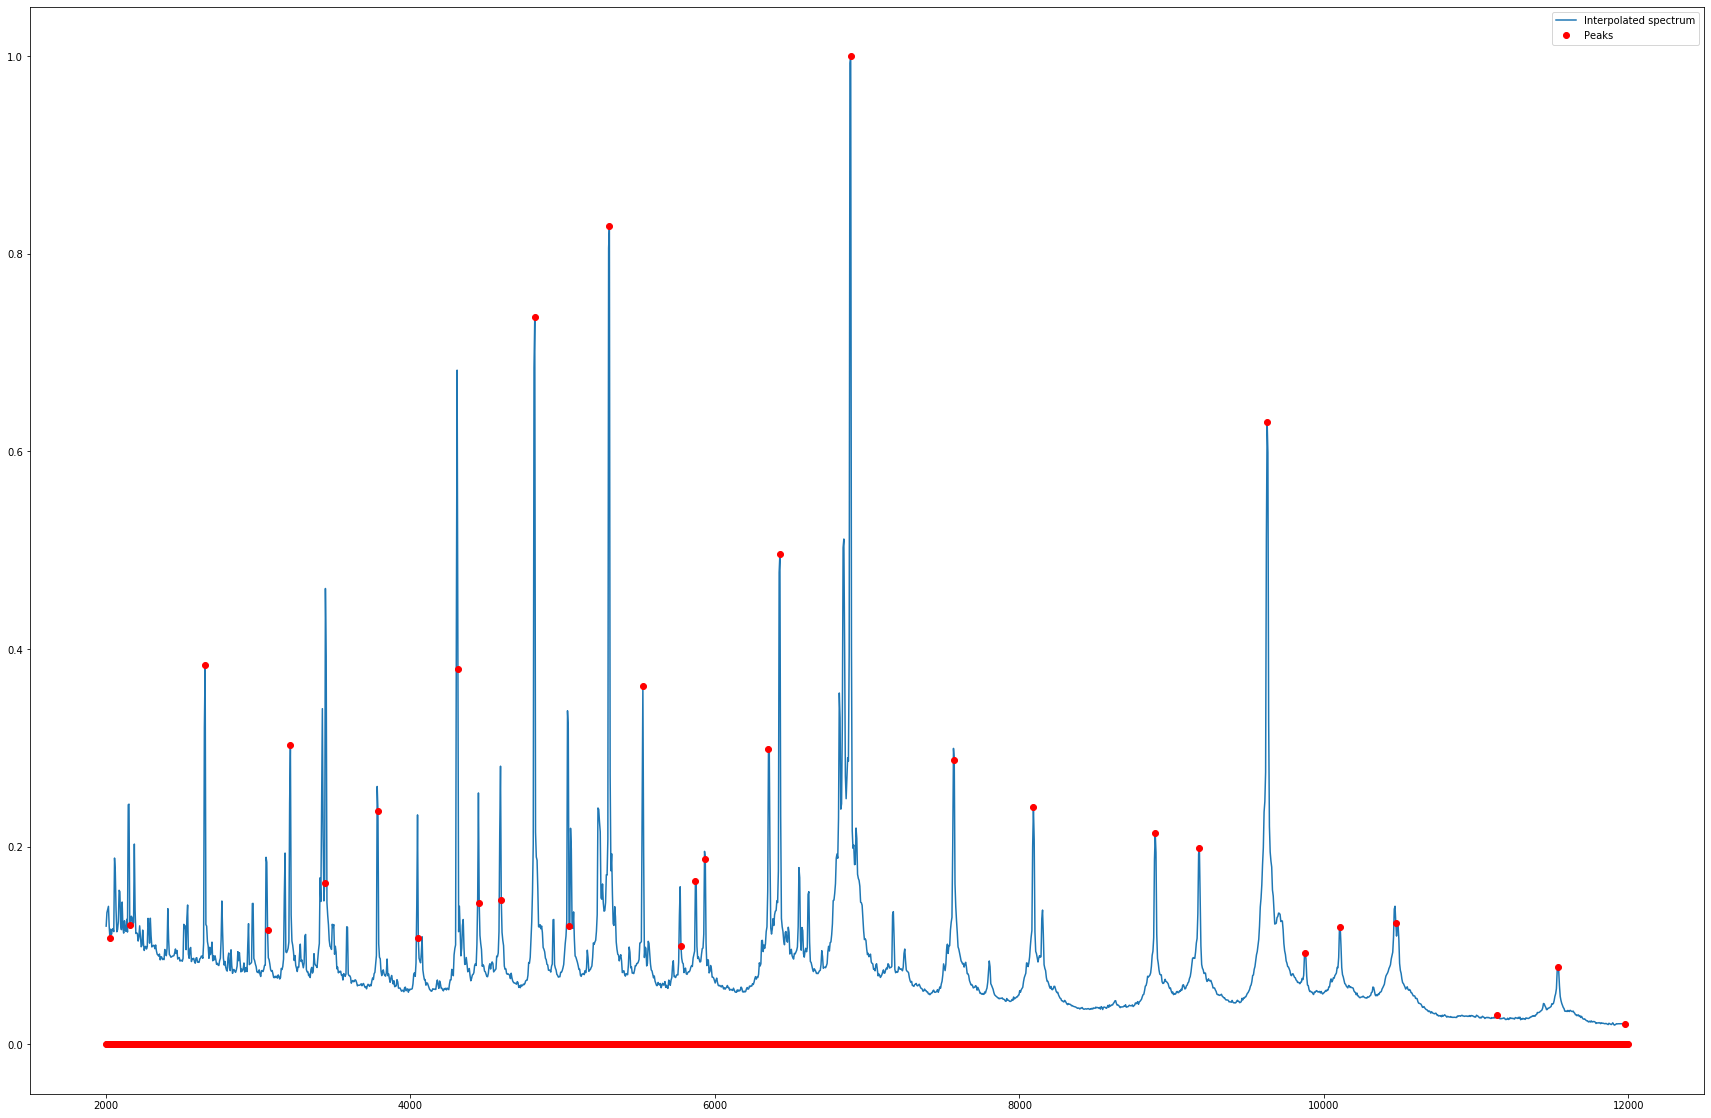

[10]
1.0 % of points


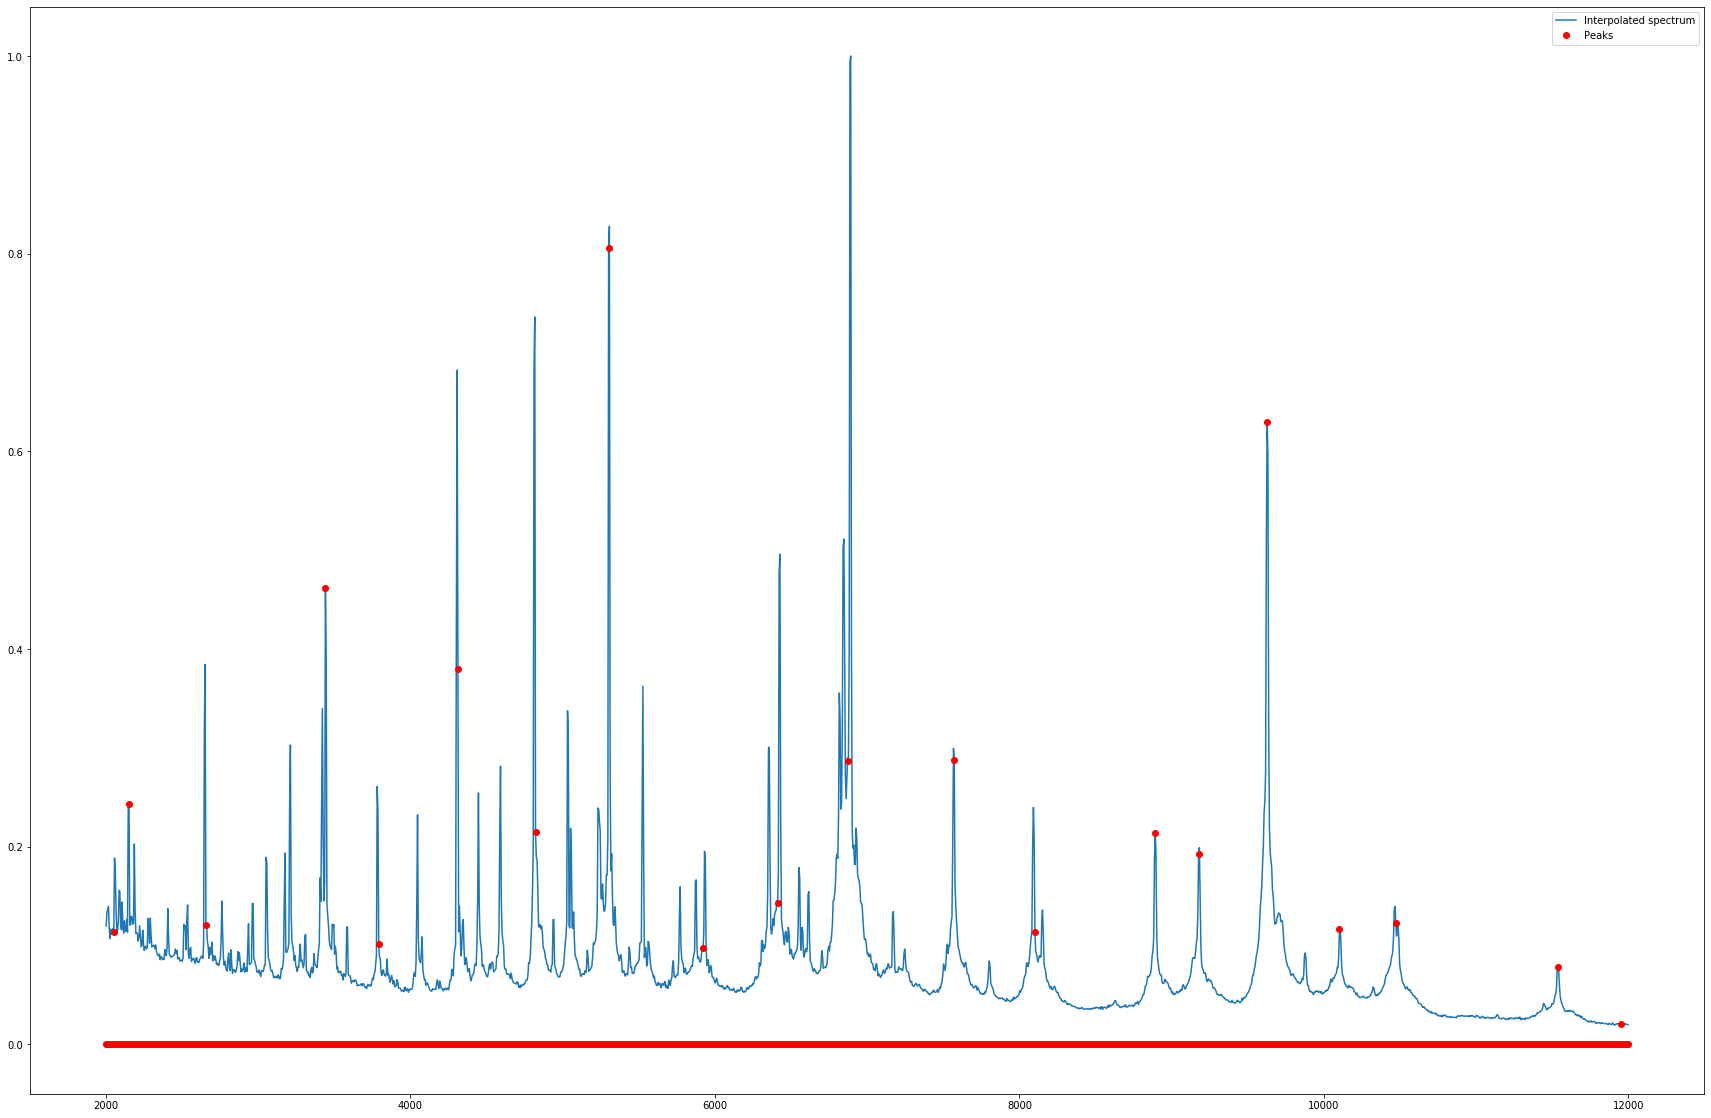

[15]
0.85 % of points


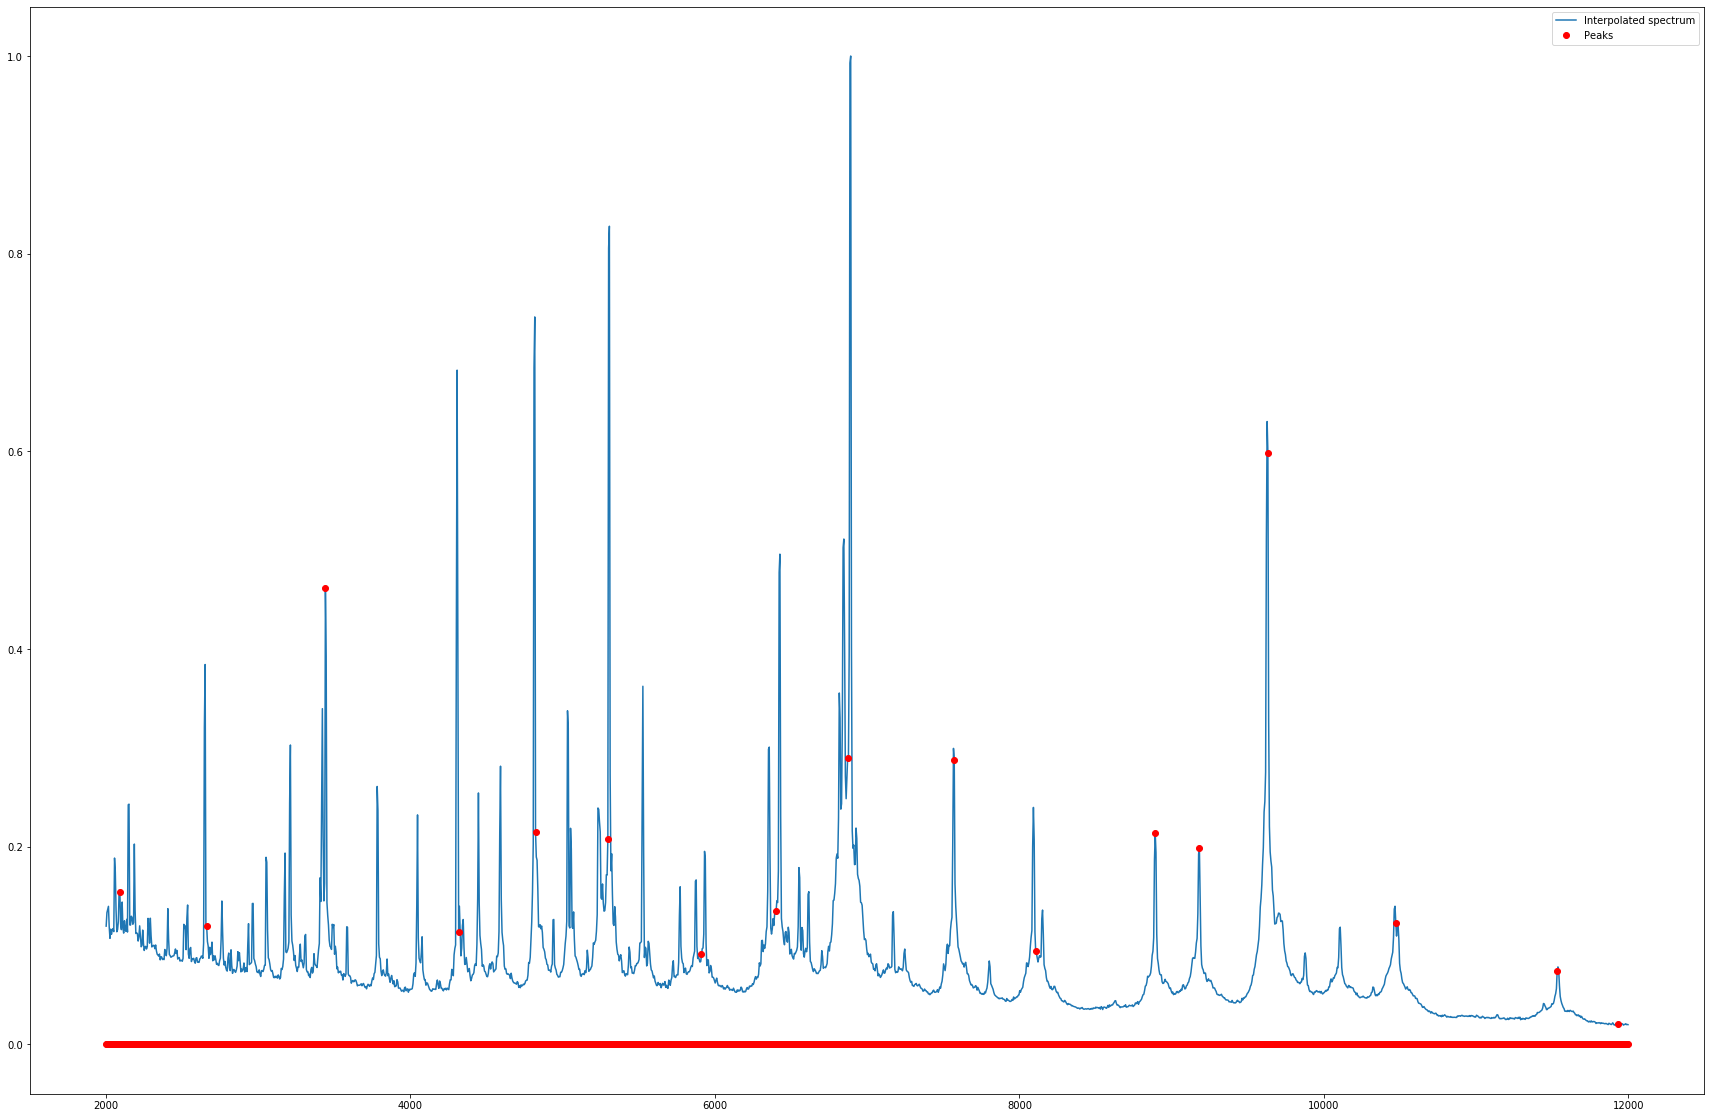

[20]
0.75 % of points


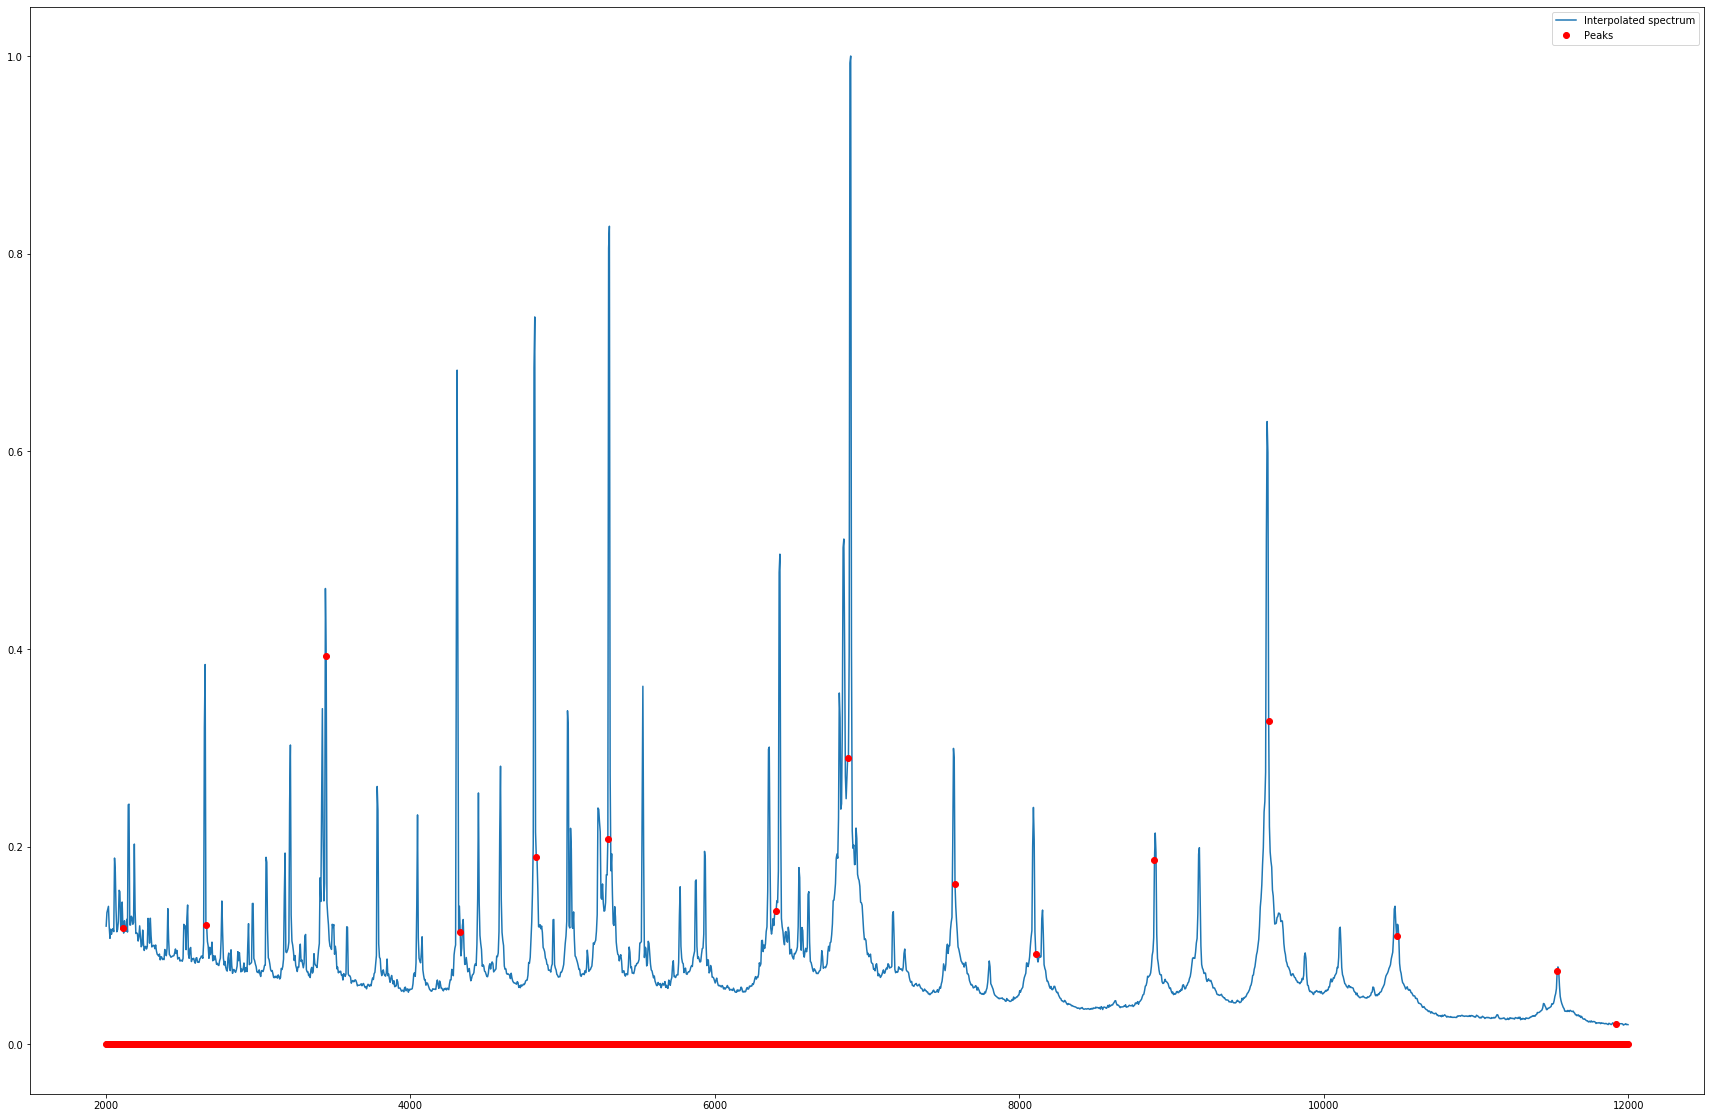

In [33]:
for i,n in enumerate([[5],[10],[15],[20]]):
    print(n)
    new_df = spectrum_in_peaks(spectrum_train2,n)
    plt.figure(figsize=(30,20))
    plt.plot(spectrum_train2.iloc[0,:],label='Interpolated spectrum')
    plt.plot(new_df.iloc[0,:],'ro',label='Peaks')
    print(np.round(np.sum(new_df.iloc[0,:]>0) *100/ len(new_df.iloc[0,:]),2) ,'% of points')
    plt.legend()
    plt.show()

[1]
3.85 % of points


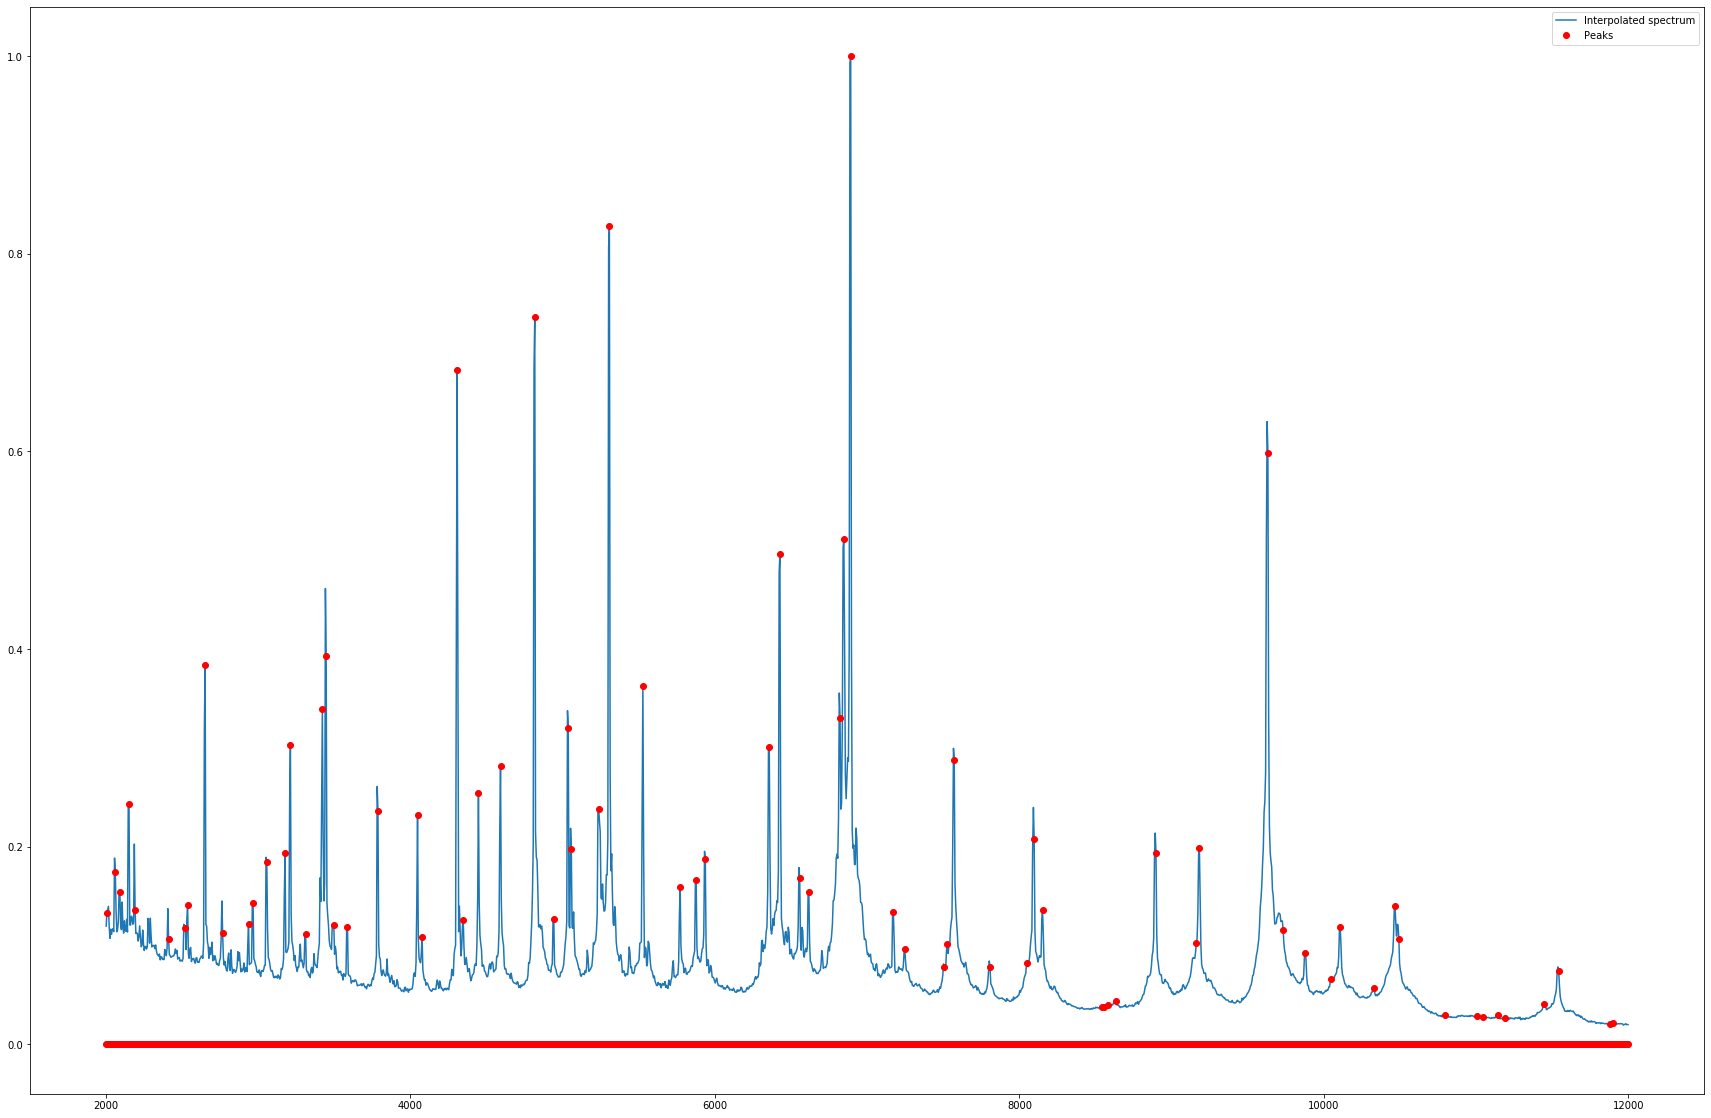

[2]
2.75 % of points


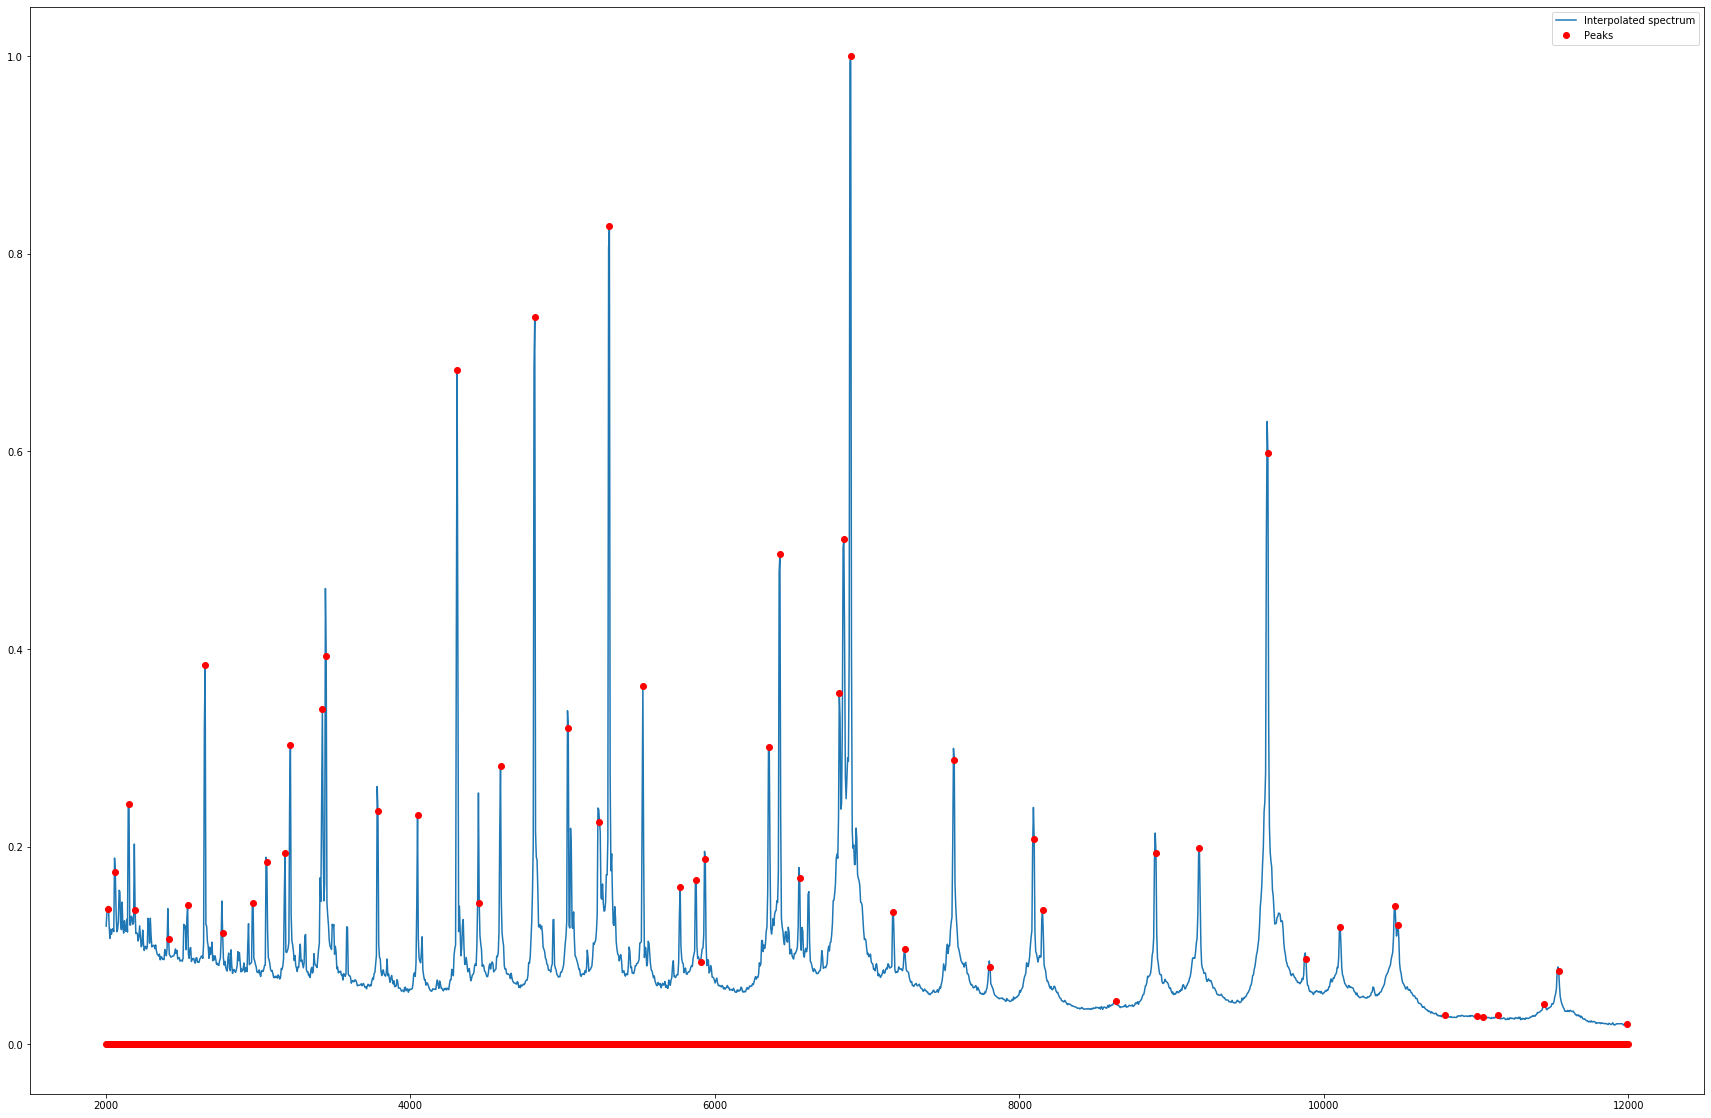

[3]
2.3 % of points


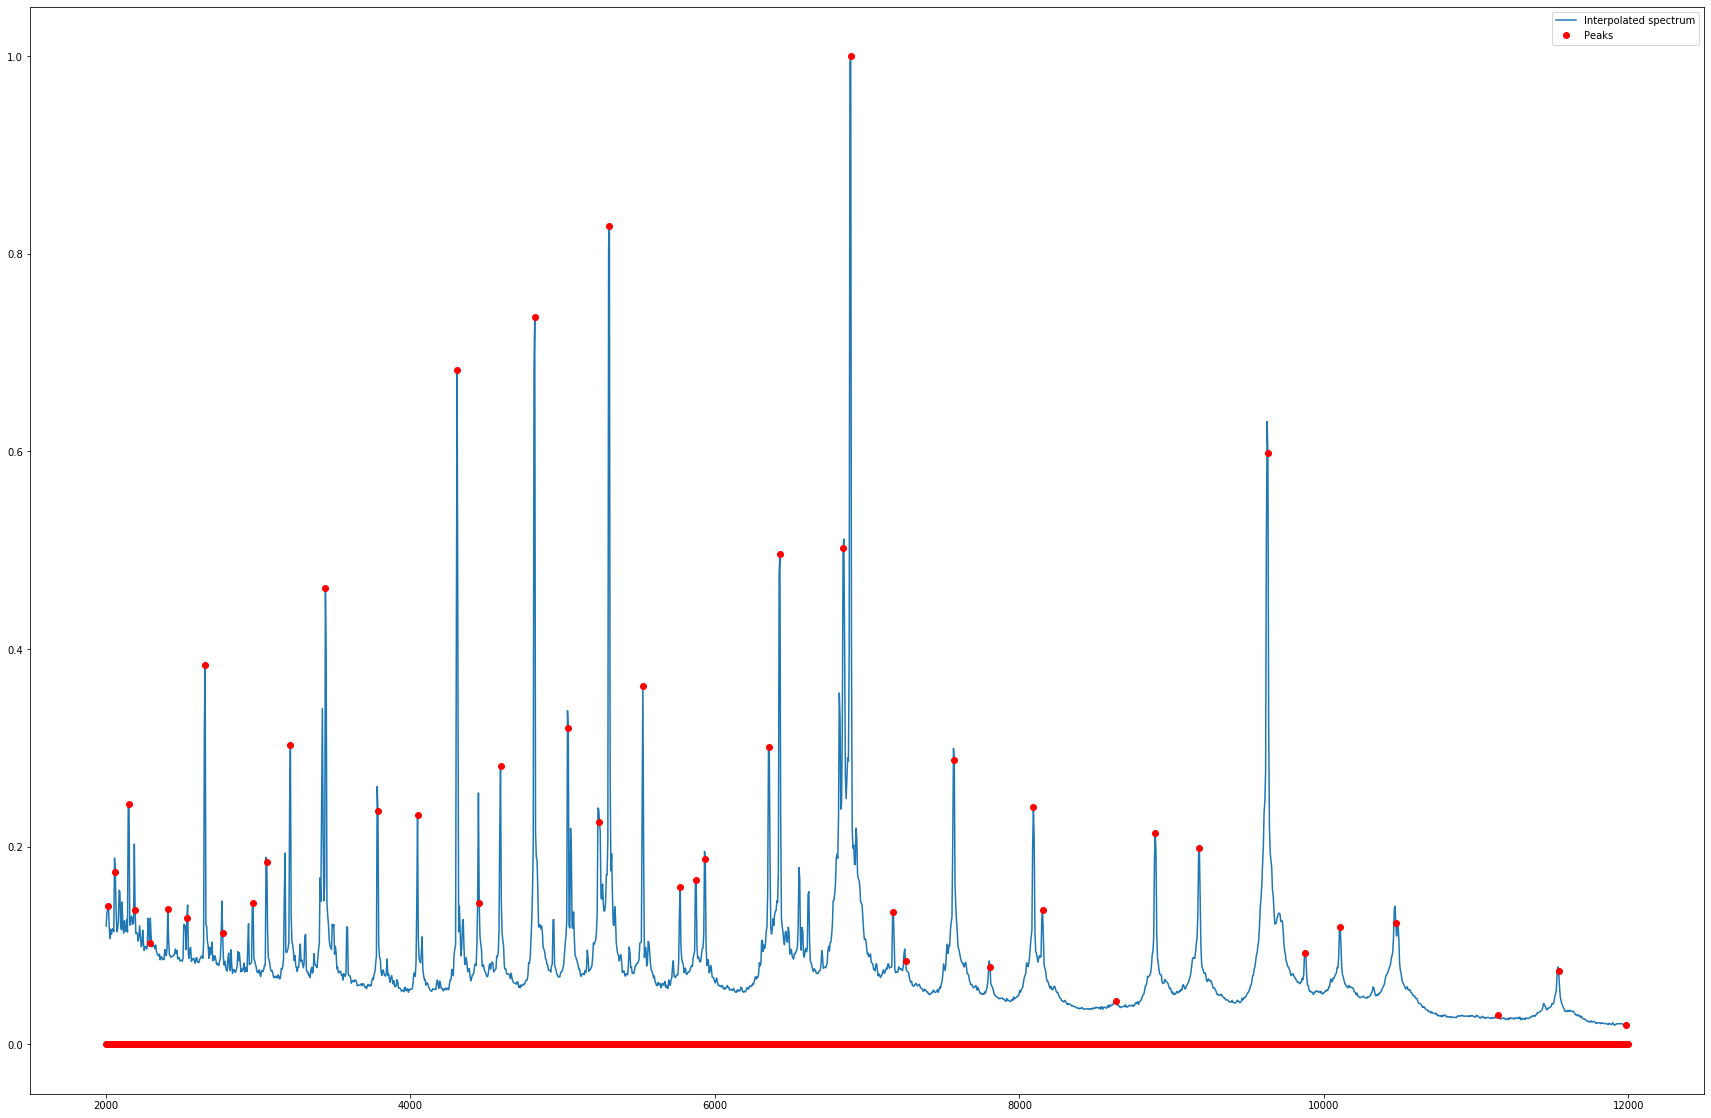

In [34]:
for i,n in enumerate([[1],[2],[3]]):
    print(n)
    new_df = spectrum_in_peaks(spectrum_train2,n)
    plt.figure(figsize=(30,20))
    plt.plot(spectrum_train2.iloc[0,:],label='Interpolated spectrum')
    plt.plot(new_df.iloc[0,:],'ro',label='Peaks')
    print(np.round(np.sum(new_df.iloc[0,:]>0) *100/ len(new_df.iloc[0,:]),2) ,'% of points')
    plt.legend()
    plt.show()

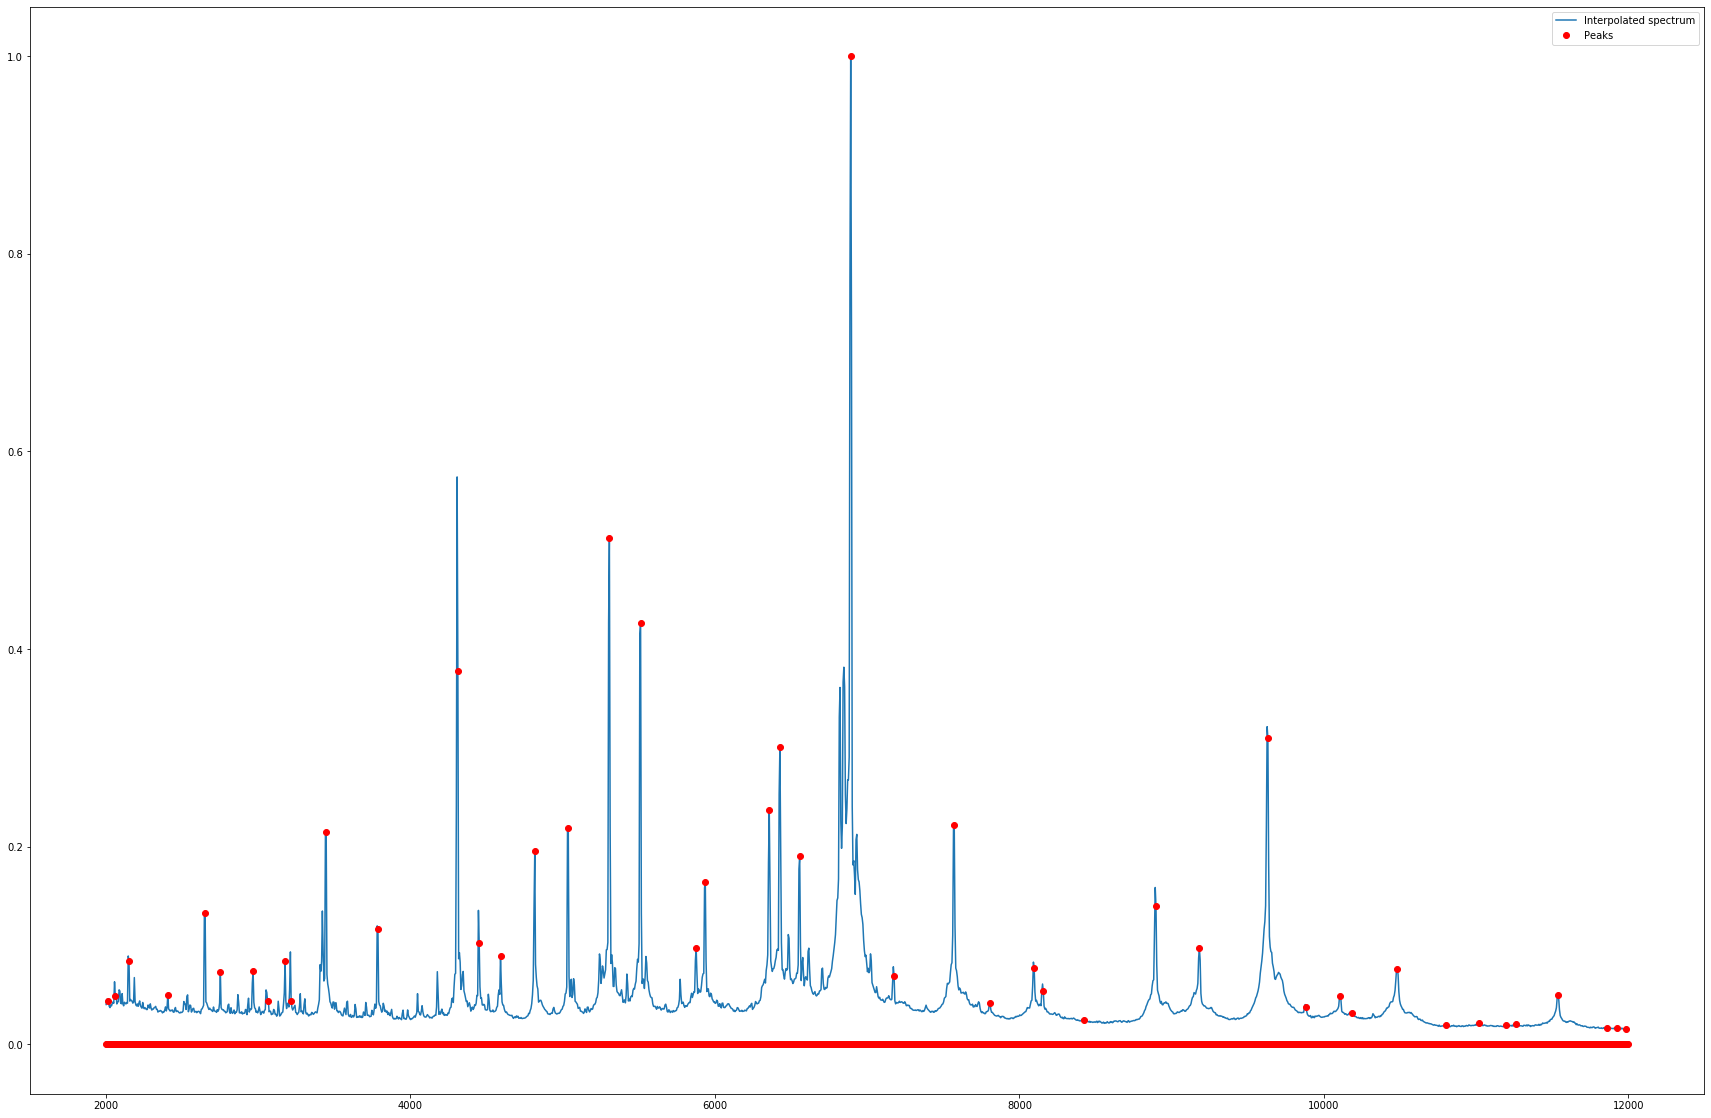

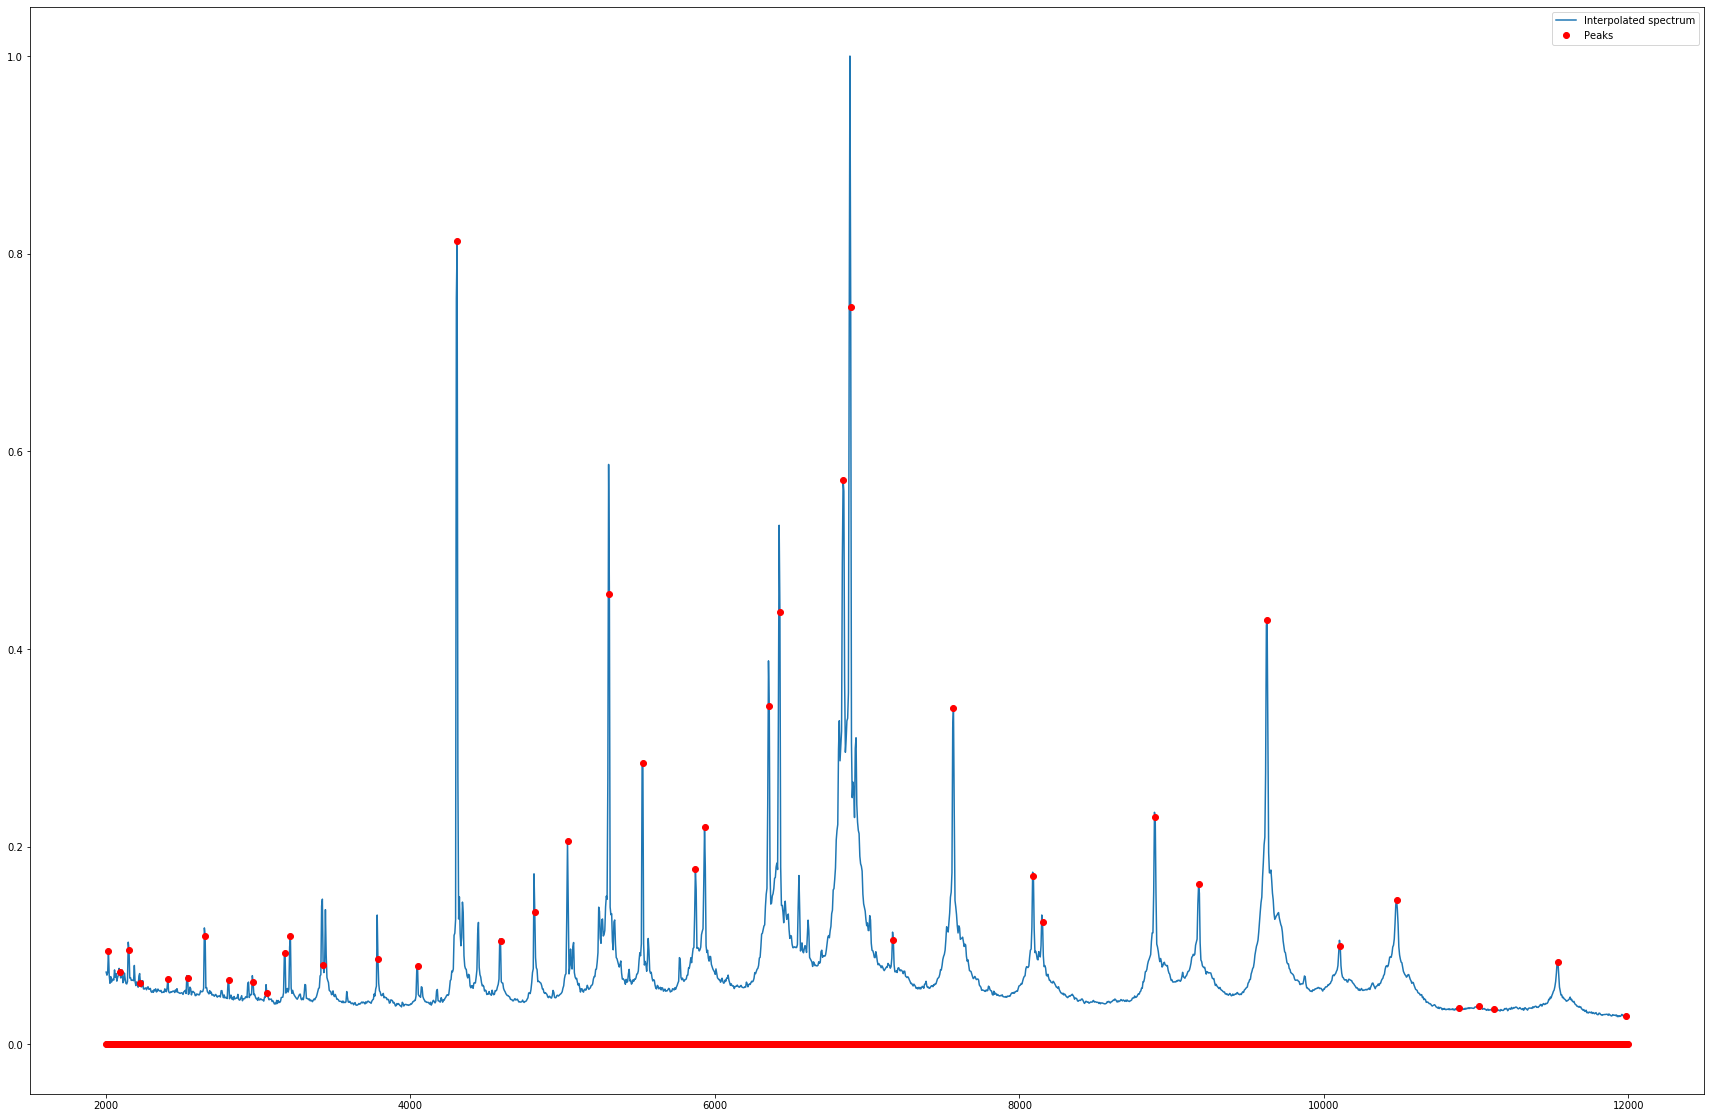

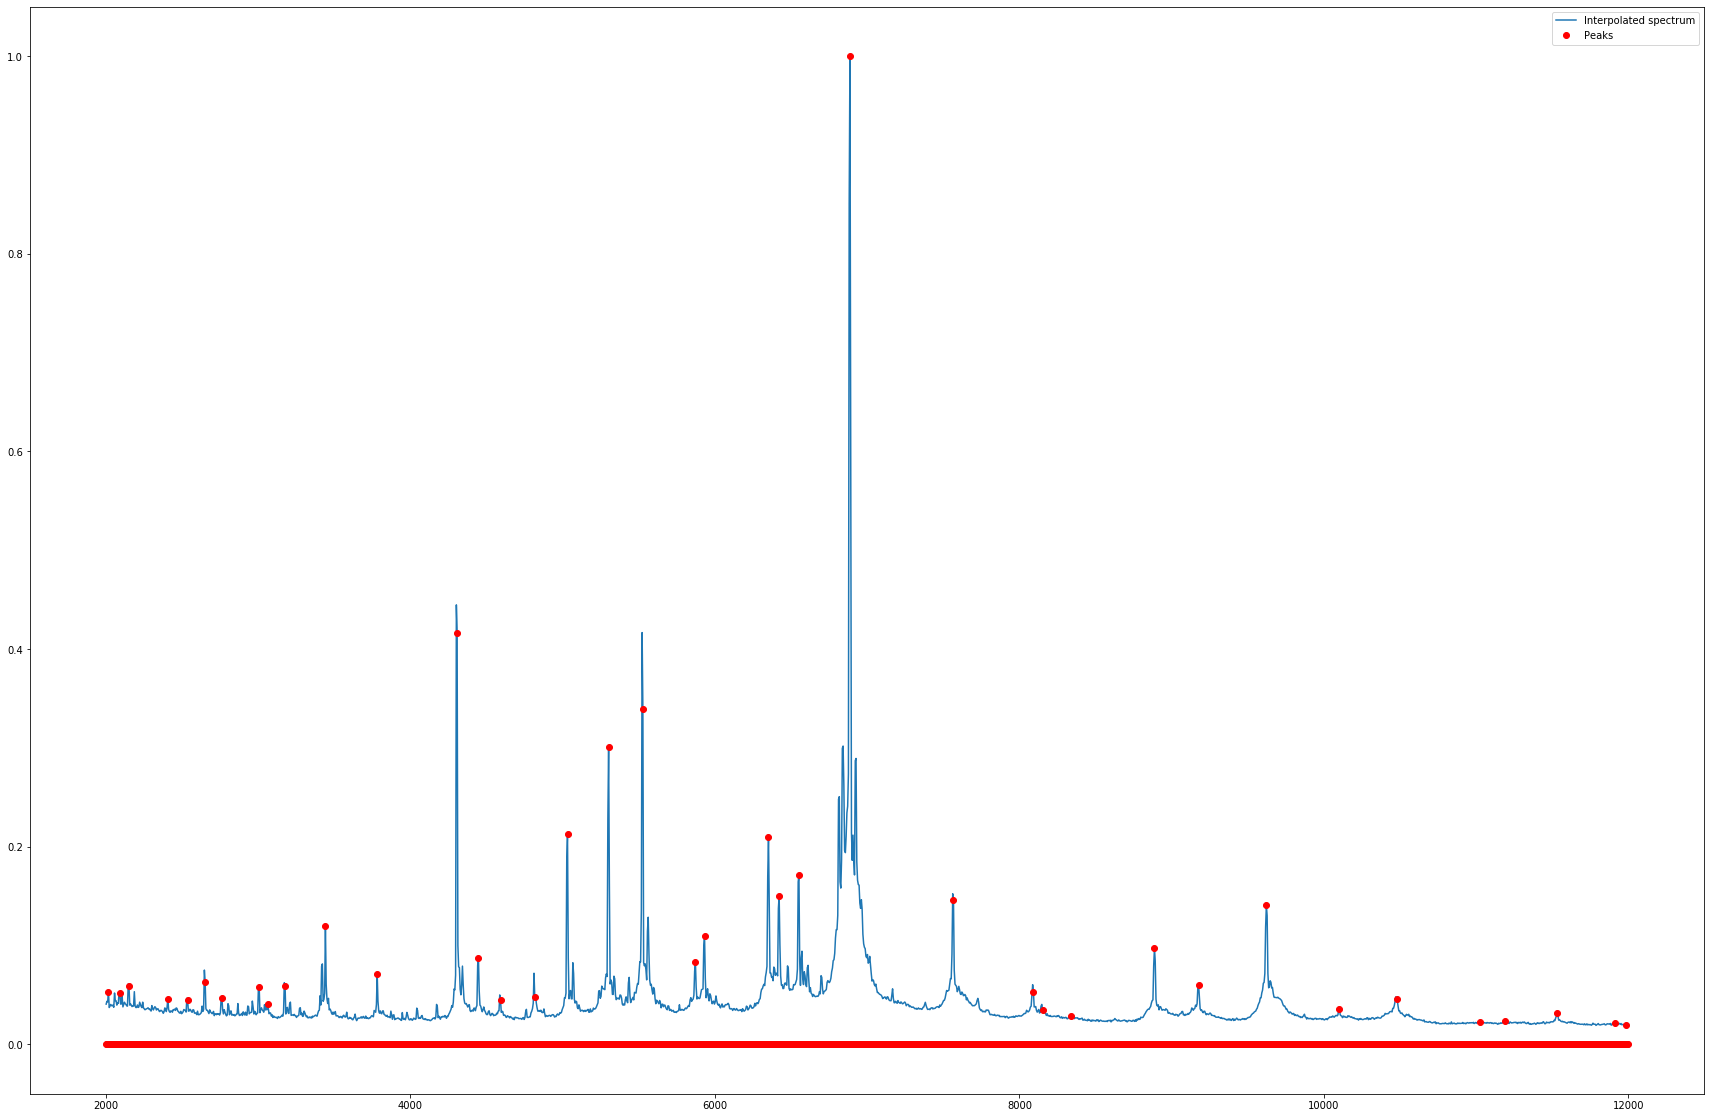

In [36]:
for i in [42,100,250]:
    plt.figure(figsize=(30,20))
    plt.plot(spectrum_train2.iloc[i,:],label='Interpolated spectrum')
    plt.plot(new_df.iloc[i,:],'ro',label='Peaks')
    plt.legend()
    plt.show()